# Baseline for Hot Topics in Computer Vision - Seminar 2
## Addressing Label Scarcity in the Semantic Analysis of Earth Observation Imagery

## Imports

In [22]:
#google colab
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from sklearn.metrics import roc_curve, auc, confusion_matrix
from PIL import Image

In [23]:
#from google.colab import drive
#drive.mount('/content/drive')

## Constants

In [24]:
# Mappings for utility
MAP_PERCENT_TO_AMOUNT = {
    "10" : 280,
    "25" : 700,
    "50" : 1400,
    "100": 2799
}

DAMAGE_LEVEL_TO_SCORE = {
    "destroyed" : 4,
    "major-damage" : 3,
    "minor-damage" : 2,
    "no-damage" : 1,
}

## Configs

In [59]:
PERCENT = "10"
TRAIN_SET_SIZE = MAP_PERCENT_TO_AMOUNT[PERCENT]
BATCH_SIZE = 32

In [26]:
os.listdir("../dataset/")

['test', 'train', 'xview2.txt', 'hold']

## File Paths

In [39]:
DATASET_DIR = "../dataset/"
DATASET_METRICS_DIR = "../dataset_metrics"
XVIEW2_TXT_FILE = "../dataset/xview2.txt"
MODEL_OUTPUT_DIR = "../models/"
MODEL_OUTPUT_FILE = "model.pth"

In [28]:
!ls /datasets/xviewdataset/HTCV-Sem/dataset/

ls: /datasets/xviewdataset/HTCV-Sem/dataset/: No such file or directory


## Baseline Classifier

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet18(weights=None)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x
    
    def train_model(self, dataloader, num_epochs, lr, momentum):
        self.train()
        self.to(device)

        optimizer = torch.optim.SGD(self.parameters(), lr, momentum)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        # Train the model

        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels in dataloader:
                images, labels =  images.to(device),labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = self(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimizatio.n
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            scheduler.step()
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")
        torch.save(self.state_dict(), MODEL_OUTPUT_FILENAME + '.pth')
    # Define the evaluation function

    
    def evaluate_model(self, test_dataloader):
        self.eval()  # Set the model to evaluation mode
        self.to(device)

        correct = 0
        total = 0

        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        accuracy = correct / total
        confusion_mat = confusion_matrix(true_labels, predicted_labels)

        metrics = {}
        roc_curves = {}
        for class_idx in range(confusion_mat.shape[0]):
            TP = confusion_mat[class_idx, class_idx]
            FN = confusion_mat[class_idx, :].sum() - TP
            FP = confusion_mat[:, class_idx].sum() - TP
            TN = confusion_mat.sum() - TP - FN - FP

            # Calculate metrics
            sensitivity = TP / (TP + FN) if (TP + FN) != 0 else np.nan
            precision = TP / (TP + FP) if (TP + FP) != 0 else np.nan
            specificity = TN / (TN + FP) if (TN + FP) != 0 else np.nan
            f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else np.nan

            # Calculate ROC curve
            class_probs = torch.softmax(outputs, dim=1)
            class_probs = class_probs[:, class_idx].cpu().numpy()

            # Save metrics and ROC curve for the current class
            metrics[class_idx] = {
                'Sensitivity/Recall': sensitivity,
                'Precision': precision,
                'Specificity': specificity,
                'F1-Score': f1_score
            }

        confusion_mat = confusion_matrix(true_labels, predicted_labels, normalize="true")
        return accuracy, confusion_mat, metrics, roc_curves


## Data Utilities

In [30]:
def calc_mean_and_std_of_dataset(loader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_size

    mean /= total_samples
    std /= total_samples
    
    return mean, std

## Normalize Dataset

Calculate mean and standard deviation for RGB images.

Set SAVE_MEAN_AND_STD True to recalculate the dataset's mean and standard deviation

Set LOAD_MEAN_AND_STD True to load the already calculated mean and standard deviation

In [60]:
TRAINING_SET_ENTRIES = open(XVIEW2_TXT_FILE,'r').read().splitlines()[:TRAIN_SET_SIZE]

SAVE_MEAN_AND_STD = False
if SAVE_MEAN_AND_STD:
    pre_norm_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    # Calculate the mean and standard deviation of your dataset
    path_to_dataset = os.path.join(DATASET_DIR,"train")
    dataset = torchvision.datasets.ImageFolder(path_to_dataset, transform=pre_norm_transform)
    data_point_names = TRAINING_SET_ENTRIES

    subset = [dataset[dataset.imgs.index((file_path, class_label))] for file_path, class_label in dataset.imgs if os.path.basename(file_path) in data_point_names]
    dataloader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=False)

    mean, std = calc_mean_and_std_of_dataset(loader=dataloader)

    if not os.path.exists(DATASET_METRICS_DIR):
            os.makedirs(DATASET_METRICS_DIR)    
    with open(os.path.join(DATASET_METRICS_DIR, "data_"+ str(MAP_PERCENT_TO_AMOUNT[PERCENT])+"_original" +".json"), 'w') as json_file:
        json.dump({'mean':mean.tolist(),'std':std.tolist()}, json_file)

In [61]:
LOAD_MEAN_AND_STD = True
if LOAD_MEAN_AND_STD:
    with open(os.path.join(DATASET_METRICS_DIR, "data_"+ str(MAP_PERCENT_TO_AMOUNT[PERCENT])+"_original" +".json"), 'r') as data_metrics_json:
        data = json.load(data_metrics_json)

    mean = data['mean']
    std = data['std']
print(mean)
print(std)

[0.3047824501991272, 0.336587131023407, 0.2517954707145691]
[0.11718715727329254, 0.10339520871639252, 0.09869235008955002]


## Setup training model

In [95]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset = torchvision.datasets.ImageFolder(
    path_to_dataset, transform=transform
)
subset = [dataset[dataset.imgs.index((file_path, class_label))] 
          for file_path, class_label in dataset.imgs
            if os.path.basename(file_path) in data_point_names]
dataloader = torch.utils.data.DataLoader(
    subset, batch_size=BATCH_SIZE, shuffle=True
)

KeyboardInterrupt: 

Train model

In [ ]:
# Train the model
num_classes = 5  # Number of output classes

num_epochs=15
lr=0.01
momentum=0.9
model = ResNetClassifier(num_classes)

model.train_model(dataloader, num_epochs, lr, momentum)


Epoch 1/15, Loss: 65.88868606090546
Epoch 2/15, Loss: 66.28035509586334
Epoch 3/15, Loss: 56.04221922159195
Epoch 4/15, Loss: 53.96895790100098
Epoch 5/15, Loss: 49.41043972969055
Epoch 6/15, Loss: 48.404438734054565
Epoch 7/15, Loss: 48.160044491291046


KeyboardInterrupt: 

Setup evaluating test performance

In [ ]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET_FOLDER_PATH, "test"), transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=2, pin_memory=True)

Evaluate model on test data

In [ ]:

LOAD_MODEL = False
LOAD_MODEL_PATH = 'resnet_classifier.pth'
#Load the saved model state dictionary
if(LOAD_MODEL):
  model = ResNetClassifier(num_classes)
  model.load_state_dict(torch.load('resnet_classifier.pth'))

# Evaluate the model
accuracy, confusion_mat, metrics, roc_curve = model.evaluate_model(test_dataloader=test_dataloader)

# Print the accuracy
print(f"Accuracy: {accuracy}")

print("Confusion Matrix:")
print(confusion_mat)

print("Metrics")
print(json.dumps(metrics, indent=2))


Accuracy: 0.5348338692390139
Confusion Matrix:
[[0.63402062 0.21649485 0.03092784 0.04639175 0.07216495]
 [0.08060453 0.7884131  0.05793451 0.03274559 0.04030227]
 [0.15942029 0.61594203 0.07971014 0.07971014 0.06521739]
 [0.13445378 0.3697479  0.12605042 0.2605042  0.1092437 ]
 [0.22352941 0.30588235 0.09411765 0.12941176 0.24705882]]
Metrics
{
  "0": {
    "Sensitivity/Recall": 0.634020618556701,
    "Precision": 0.5801886792452831,
    "Specificity": 0.8795669824086604,
    "F1-Score": 0.6059113300492611
  },
  "1": {
    "Sensitivity/Recall": 0.7884130982367759,
    "Precision": 0.6137254901960785,
    "Specificity": 0.6324626865671642,
    "F1-Score": 0.6901874310915105
  },
  "2": {
    "Sensitivity/Recall": 0.07971014492753623,
    "Precision": 0.1746031746031746,
    "Specificity": 0.9345911949685535,
    "F1-Score": 0.10945273631840796
  },
  "3": {
    "Sensitivity/Recall": 0.2605042016806723,
    "Precision": 0.41333333333333333,
    "Specificity": 0.9459459459459459,
    "F

In [ ]:
mean_val = [mean_i.item() for mean_i in mean]
std_val = [std_i.item() for std_i in std]
data_info = {
    'dataset_size' : MAP_PERCENT_TO_AMOUNT[PERCENT],
    'mean_0' : mean_val[0],
    'mean_1' : mean_val[1],
    'mean_2' : mean_val[2],
    'standard_dev_0' : std_val[0],
    'standard_dev_1' : std_val[1],
    'standard_dev_2' : std_val[2]
}
model_info = {
    'dataset_size' : MAP_PERCENT_TO_AMOUNT[PERCENT],
    'architecture' : "resnet18",
    'learning_rate': lr,
    'batch_size': BATCH_SIZE,
    'num_epochs': num_epochs,
    'momentum' : momentum,
    'accuracy' : accuracy,
    'confusion_mat' : confusion_mat.tolist()
}
with open("dataset_size_" + str(MAP_PERCENT_TO_AMOUNT[PERCENT]) +'.json', 'w') as file:
    json.dump(data_info, file)

with open(MODEL_OUTPUT_FILENAME +'.json', 'w') as file:
    json.dump(model_info, file)

Visualize Results

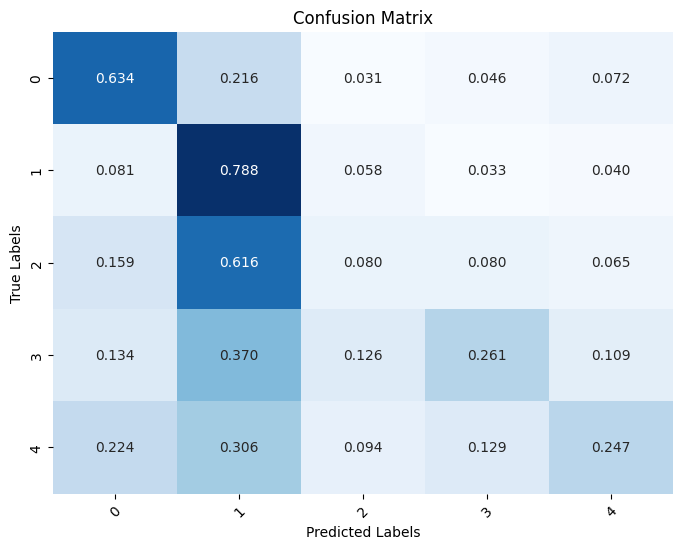

In [ ]:
# Get the class labels
class_labels = test_dataset.classes

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt=".3f", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels and title
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ac044641-96a0-4e06-ae59-4421e551585a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>